In [1]:
import os
work_dir = './'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/pollard/data/projects/zhhu/cellwalk/pbmc/pbmc10k/tmp/'

In [2]:
fragments_dict = {'10x_pbmc': os.path.join('../', 'pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz')}

In [3]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))


In [ ]:
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [4]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [10]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 #remove_duplicates = True,
                 temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

2024-01-26 16:18:03,342 cisTopic     INFO     Splitting fragments by cell type.
2024-01-26 16:20:28,729 cisTopic     INFO     generating bigwig files
Add chromosome sizes to bigWig header
Number of fragments: 1927410
Split fragments df by chromosome
Calculate depth per chromosome:
  - GL000194.1 ...
  - GL000195.1 ...
  - GL000205.2 ...
  - GL000219.1 ...
  - KI270711.1 ...
  - KI270713.1 ...
  - KI270721.1 ...
  - KI270726.1 ...
  - KI270727.1 ...
  - KI270728.1 ...
  - KI270734.1 ...
  - chr1 ...
  - chr10 ...
  - chr11 ...
  - chr12 ...
  - chr13 ...
  - chr14 ...
  - chr15 ...
  - chr16 ...
  - chr17 ...
  - chr18 ...
  - chr19 ...
  - chr2 ...
  - chr20 ...
  - chr21 ...
  - chr22 ...
  - chr3 ...
  - chr4 ...
  - chr5 ...
  - chr6 ...
  - chr7 ...
  - chr8 ...
  - chr9 ...
  - chrX ...
  - chrY ...
Compact depth array per chromosome (make ranges for consecutive the same values and remove zeros):
  - Compact GL000008.2 ...
  - Compact GL000009.2 ...
  - Compact GL000194.1 ...
  - 

In [11]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [15]:
#import pickle
#bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
#bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=8,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05)
                                 #_temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2024-01-26 16:30:08,144	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(macs_call_peak_ray pid=3054898) 2024-01-26 16:30:11,179 cisTopic     INFO     Calling peaks for B_cells_2 with macs2 callpeak --treatment ./scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.fragments.tsv.gz --name B_cells_2  --outdir ./scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=3054902) 2024-01-26 16:30:11,169 cisTopic     INFO     Calling peaks for Dendritic_cells with macs2 callpeak --treatment ./scATAC/consensus_peak_calling/pseudobulk_bed_files/Dendritic_cells.fragments.tsv.gz --name Dendritic_cells  --outdir ./scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=3054897) 2024-01-26 16:30:11,176 cisTopic     INFO     Calling peaks for NK_cells with macs2 callpeak --treatment ./scATAC/consensus_peak_calling/pseudobulk_b

In [16]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [18]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= '../hg38-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2024-01-26 16:39:24,030 cisTopic     INFO     Extending and merging peaks per class
2024-01-26 16:40:32,040 cisTopic     INFO     Normalizing peak scores
2024-01-26 16:40:32,438 cisTopic     INFO     Merging peaks
2024-01-26 16:41:44,287 cisTopic     INFO     Done!


In [19]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

In [20]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

/tmp/ipykernel_3046043/2503884162.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


2024-01-26 16:44:06,956 cisTopic     INFO     Reading 10x_pbmc
2024-01-26 16:46:20,527 cisTopic     INFO     Computing barcode rank plot for 10x_pbmc
2024-01-26 16:46:20,528 cisTopic     INFO     Counting fragments
2024-01-26 16:46:27,788 cisTopic     INFO     Marking barcodes with more than 100
2024-01-26 16:46:27,827 cisTopic     INFO     Returning plot data
2024-01-26 16:46:27,829 cisTopic     INFO     Returning valid barcodes
2024-01-26 16:46:36,252 cisTopic     INFO     Computing duplicate rate plot for 10x_pbmc
2024-01-26 16:46:46,282 cisTopic     INFO     Return plot data
2024-01-26 16:46:46,435 cisTopic     INFO     Computing insert size distribution for 10x_pbmc
2024-01-26 16:46:46,436 cisTopic     INFO     Counting fragments
2024-01-26 16:46:50,649 cisTopic     INFO     Returning plot data
2024-01-26 16:48:05,145 cisTopic     INFO     Computing TSS profile for 10x_pbmc
2024-01-26 16:48:15,483 cisTopic     INFO     Formatting annnotation
2024-01-26 16:48:15,548 cisTopic     IN

In [ ]:
                         #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
bc_passing_filters = {'10x_pbmc':[]}
bc_passing_filters['10x_pbmc'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_pbmc'])} barcodes passed QC stats")

10947 barcodes passed QC stats


In [23]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [24]:
import pickle
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [25]:
print(f"{len(list(set(bc_passing_filters['10x_pbmc']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

9832 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


In [26]:
from pycisTopic.cistopic_class import *
key = '10x_pbmc'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

2024-01-26 19:31:11,498 cisTopic     INFO     Reading data for 10x_pbmc
2024-01-26 19:33:15,324 cisTopic     INFO     metrics provided!
2024-01-26 19:33:24,620 cisTopic     INFO     valid_bc provided, selecting barcodes!
2024-01-26 19:33:32,793 cisTopic     INFO     Counting fragments in regions
2024-01-26 19:34:55,421 cisTopic     INFO     Creating fragment matrix


/pollard/home/zhhu/miniconda3/envs/scenicplus/lib/python3.10/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 3192076784 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2024-01-26 19:35:57,476 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-01-26 19:36:10,697 cisTopic     INFO     Removing blacklisted regions
2024-01-26 19:36:11,986 cisTopic     INFO     Creating CistopicObject
2024-01-26 19:36:14,650 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project 10x_pbmc with n_cells × n_regions = 9832 × 324662


In [27]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [29]:
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=8,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None)
                    #_temp_dir = os.path.join(tmp_dir + 'ray_spill'))

2024-01-26 19:39:46,125	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_cgs_model pid=3119197) 2024-01-26 19:39:48,813 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=3119197) 2024-01-26 22:23:47,358 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=3119192) 2024-01-26 19:39:49,257 cisTopic     INFO     Running model with 48 topics [repeated 5x across cluster]
(run_cgs_model pid=3119195) 2024-01-26 22:50:11,352 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=3119196) 2024-01-27 00:09:15,214 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=3119193) 2024-01-27 01:30:36,038 cisTopic     INFO     Model with 16 topics done!
(run_cgs_model pid=3119194) 2024-01-27 09:20:55,019 cisTopic     INFO     Model with 32 topics done!
(run_cgs_model pid=3119192) 2024-01-27 18:15:12,317 cisTopic     INFO     Model with 48 topics done!


In [30]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

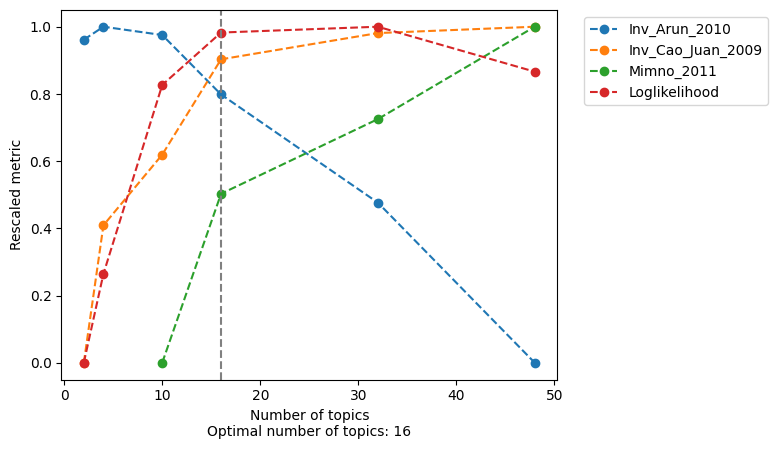

In [34]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [43]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

2024-01-29 11:18:27,396 cisTopic     INFO     Running UMAP


/pollard/home/zhhu/miniconda3/envs/scenicplus/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


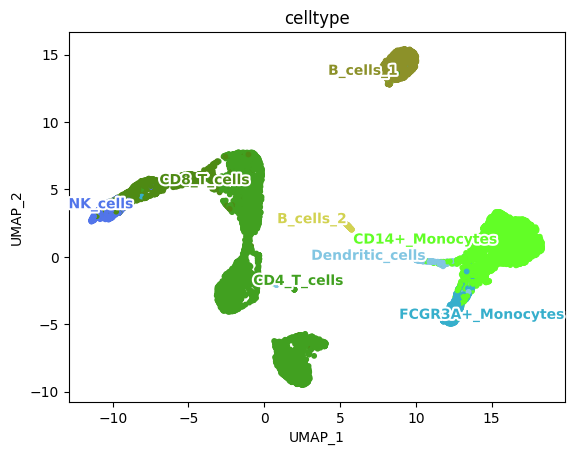

In [3]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

In [5]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

In [7]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

In [8]:
import pickle
region_bin_topics_otsu = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'rb'))
region_bin_topics_top3k = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'rb'))
markers_dict = pickle.load(open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'rb'))

In [9]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [10]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3: dict_keys(['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs: dict_keys(['B_cells_1', 'B_cells_2', 'CD14+_Monocytes', 'CD4_T_cells', 'CD8_T_cells', 'Dendritic_cells', 'FCGR3A+_Monocytes', 'NK_cells'])


In [18]:
db_fpath = "./"
motif_annot_fpath = "./"

In [19]:
rankings_db = os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(motif_annot_fpath, 'motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl')

In [12]:
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))

In [ ]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 8,
    #_temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust',
    )

In [22]:
import dill
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

In [23]:
menr['DEM_topics_otsu_All'].DEM_results('Topic8')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
metacluster_143.14,,Topic8,ZNF320,NaN,0.863156,0.000271,0.514203,0.282683,3.0,1033.0
transfac_pro__M06492,,Topic8,NaN,ZNF770,0.74169,0.037628,0.309506,0.185097,3.0,813.0
homer__GTGGGCCCCA_ZNF692,,Topic8,ZNF692,NaN,0.723539,0.032949,0.446663,0.270504,3.0,906.0
tfdimers__MD00536,,Topic8,"PPARG, EBF1",NaN,0.687115,0.018475,0.375291,0.233091,3.0,852.0
metacluster_72.4,,Topic8,"ZNF586, ZBTB7B",NaN,0.656026,0.017009,0.332172,0.210804,3.0,712.0
jaspar__MA1548.1,,Topic8,PLAGL2,NaN,0.627403,0.000002,0.835773,0.541029,3.0,1960.0
transfac_pro__M06617,,Topic8,ZNF480,NaN,0.61116,0.038142,0.367787,0.240779,3.0,946.0
jaspar__MA1986.1,,Topic8,ZNF692,NaN,0.606967,0.000024,0.933653,0.613014,3.0,2846.0
metacluster_66.3,,Topic8,"ZNF257, ZNF449",NaN,0.582903,0.001918,0.685805,0.457857,3.0,1544.0
dbtfbs__ZXDB_HEK293_ENCSR559IOZ_merged_N1,,Topic8,ZXDB,NaN,0.573933,0.000009,0.929129,0.624173,3.0,2438.0


In [25]:
import dill
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import pandas
import pyranges
# Set stderr to null to avoid strange messages from ray
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')
work_dir = './'

adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))

In [26]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata.raw.to_adata(),
    cisTopic_obj = cistopic_obj,
    menr = menr,
    bc_transform_func = lambda x: f'{x}-10x_pbmc' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

2024-01-29 15:57:07,443 cisTopic     INFO     Imputing region accessibility
2024-01-29 15:57:07,445 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-01-29 15:57:08,731 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-01-29 15:57:09,992 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-01-29 15:57:11,292 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-01-29 15:57:12,546 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-01-29 15:57:13,805 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-01-29 15:57:15,073 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-01-29 15:57:16,320 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-01-29 15:57:17,577 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-01-29 15:57:18,852 cisTopic     

SCENIC+ object with n_cells x n_genes = 9832 x 26346 and n_cells x n_regions = 9832 x 317911
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'GEX_n_genes', 'GEX_doublet_score', 'GEX_predicted_doublet', 'GEX_n_genes_by_counts', 'GEX_total_counts', 'GEX_total_counts_mt', 'GEX_pct_counts_mt', 'GEX_ingest_celltype_label', 'GEX_leiden_res_0.8', 'GEX_celltype', 'ACC_Log_unique_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_Unique_nr_frag_in_regions', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_Unique_nr_frag', 'ACC_cisTopic_nr_frag', 'ACC_Dupl_rate', 'ACC_Dupl_nr_frag', 'ACC_barcode', 'ACC_TSS_enrichment', 'ACC_Total_nr_frag', 'ACC_FRIP', 'ACC_Total_nr_frag_in_regions', 'ACC_Log_total_nr_frag', 'ACC_n_genes', 'ACC_doublet_score', 'A

In [27]:
ensembl_version_dict = {'105': 'http://www.ensembl.org',
                        '104': 'http://may2021.archive.ensembl.org/',
                        '103': 'http://feb2021.archive.ensembl.org/',
                        '102': 'http://nov2020.archive.ensembl.org/',
                        '101': 'http://aug2020.archive.ensembl.org/',
                        '100': 'http://apr2020.archive.ensembl.org/',
                        '99': 'http://jan2020.archive.ensembl.org/',
                        '98': 'http://sep2019.archive.ensembl.org/',
                        '97': 'http://jul2019.archive.ensembl.org/',
                        '96': 'http://apr2019.archive.ensembl.org/',
                        '95': 'http://jan2019.archive.ensembl.org/',
                        '94': 'http://oct2018.archive.ensembl.org/',
                        '93': 'http://jul2018.archive.ensembl.org/',
                        '92': 'http://apr2018.archive.ensembl.org/',
                        '91': 'http://dec2017.archive.ensembl.org/',
                        '90': 'http://aug2017.archive.ensembl.org/',
                        '89': 'http://may2017.archive.ensembl.org/',
                        '88': 'http://mar2017.archive.ensembl.org/',
                        '87': 'http://dec2016.archive.ensembl.org/',
                        '86': 'http://oct2016.archive.ensembl.org/',
                        '80': 'http://may2015.archive.ensembl.org/',
                        '77': 'http://oct2014.archive.ensembl.org/',
                        '75': 'http://feb2014.archive.ensembl.org/',
                        '54': 'http://may2009.archive.ensembl.org/'}

import pybiomart as pbm
def test_ensembl_host(scplus_obj, host, species):
    dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
    annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    annot['Chromosome'] = annot['Chromosome'].astype('str')
    filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
    annot = annot[~filter]
    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
    gene_names_release = set(annot['Gene'].tolist())
    ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
    print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
    return ov

n_overlap = {}
for version in ensembl_version_dict.keys():
    print(f'host: {version}')
    try:
        n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'hsapiens')
    except:
        print('Host not reachable')
v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105
Genes recovered: 18787 out of 26346
host: 104
Genes recovered: 19068 out of 26346
host: 103
Genes recovered: 25696 out of 26346
host: 102
Genes recovered: 25755 out of 26346
host: 101
Genes recovered: 25851 out of 26346
host: 100
Genes recovered: 25997 out of 26346
host: 99
Genes recovered: 26063 out of 26346
host: 98
Genes recovered: 26319 out of 26346
host: 97
Genes recovered: 26002 out of 26346
host: 96
Genes recovered: 25041 out of 26346
host: 95
Genes recovered: 24842 out of 26346
host: 94
Host not reachable
host: 93
Host not reachable
host: 92
Host not reachable
host: 91
Host not reachable
host: 90
Host not reachable
host: 89
Host not reachable
host: 88
Host not reachable
host: 87
Host not reachable
host: 86
Host not reachable
host: 80
Genes recovered: 18375 out of 26346
host: 77
Genes recovered: 18071 out of 26346
host: 75
Host not reachable
host: 54
Host not reachable
version: 98 has the largest overlap, use http://sep2019.archive.ensembl.org/ as biomart host


In [28]:
biomart_host = "http://sep2019.archive.ensembl.org/"

In [37]:
!wget -O pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt

--2024-01-29 20:49:03--  http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt
Resolving humantfs.ccbr.utoronto.ca (humantfs.ccbr.utoronto.ca)... 142.150.52.218
Connecting to humantfs.ccbr.utoronto.ca (humantfs.ccbr.utoronto.ca)|142.150.52.218|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11838 (12K) [text/plain]
Saving to: ‘pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt’

pbmc_tutorial/data/ 100%[===================>]  11.56K  --.-KB/s    in 0.06s   

2024-01-29 20:49:03 (185 KB/s) - ‘pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt’ saved [11838/11838]



In [30]:
!wget -O pbmc_tutorial/bedToBigBed http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed
!chmod +x pbmc_tutorial/bedToBigBed

--2024-01-29 16:04:02--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9634984 (9.2M)
Saving to: ‘pbmc_tutorial/bedToBigBed’

pbmc_tutorial/bedTo 100%[===================>]   9.19M  --.-KB/s    in 0.05s   

2024-01-29 16:04:02 (190 MB/s) - ‘pbmc_tutorial/bedToBigBed’ saved [9634984/9634984]



In [31]:
scplus_obj.dr_cell['GEX_X_pca'] = scplus_obj.dr_cell['GEX_X_pca'].iloc[:, 0:2]
scplus_obj.dr_cell['GEX_rep'] = scplus_obj.dr_cell['GEX_rep'].iloc[:, 0:2]

In [43]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['GEX_celltype'],
        species = 'hsapiens',
        assembly = 'hg38',
        tf_file = 'pbmc_tutorial/data/utoronto_human_tfs_v_1.01.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = biomart_host,
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = True,
        export_to_loom_file = False,
        export_to_UCSC_file = True,
        path_bedToBigBed = 'pbmc_tutorial',
        n_cpu = 24,
        _temp_dir = '/pollard/data/projects/zhhu/tmp') #os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2024-01-30 12:15:03,503 SCENIC+_wrapper INFO     ./scenicplus folder already exists.
2024-01-30 12:15:03,504 SCENIC+_wrapper INFO     Calculating TF-eGRNs AUC correlation
2024-01-30 12:15:22,720 SCENIC+_wrapper INFO     Calculating DEGs/DARs
2024-01-30 12:15:22,722 SCENIC+      INFO     Calculating DEGs for variable GEX_celltype
2024-01-30 12:15:36,315 SCENIC+      INFO     There are 4294 variable features
2024-01-30 12:15:41,986 SCENIC+      INFO     Finished calculating DEGs for variable GEX_celltype
2024-01-30 12:15:41,988 SCENIC+      INFO     Calculating DARs for variable GEX_celltype
2024-01-30 12:16:44,554 SCENIC+      INFO     There are 61039 variable features
2024-01-30 12:18:27,200 SCENIC+      INFO     Finished calculating DARs for variable GEX_celltype
2024-01-30 12:18:27,201 SCENIC+_wrapper INFO     Exporting to UCSC
2024-01-30 12:18:28,311 R2G          INFO     Downloading gene annotation from biomart, using dataset: hsapiens_gene_ensembl
2024-01-30 12:18:42,313 R2G      

In [44]:
scplus_obj

SCENIC+ object with n_cells x n_genes = 9832 x 26346 and n_cells x n_regions = 9832 x 317911
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
	metadata_cell:'GEX_n_genes', 'GEX_doublet_score', 'GEX_predicted_doublet', 'GEX_n_genes_by_counts', 'GEX_total_counts', 'GEX_total_counts_mt', 'GEX_pct_counts_mt', 'GEX_ingest_celltype_label', 'GEX_leiden_res_0.8', 'GEX_celltype', 'ACC_Log_unique_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_Unique_nr_frag_in_regions', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc', 'ACC_Unique_nr_frag', 'ACC_cisTopic_nr_frag', 'ACC_Dupl_rate', 'ACC_Dupl_nr_frag', 'ACC_barcode', 'ACC_TSS_enrichment', 'ACC_Total_nr_frag', 'ACC_FRIP', 'ACC_Total_nr_frag_in_regions', 'ACC_Log_total_nr_frag', 'ACC_n_genes', 'ACC_doublet_score', 'A

In [45]:
scplus_obj.to_df('EXP').head()

,AL627309.1,AL627309.5,AL627309.4,AL669831.2,LINC01409,FAM87B,LINC01128,LINC00115,FAM41C,AL645608.6,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC004556.3,AC007325.1,AC007325.4
GATGCTTAGCGGATTT-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.153478,0.0,0.00000,0.0,0.0
GGCTGTCAGTCCTTCA-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
AAAGGCTCAGGACACA-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.406970,0.0,1.40697,0.0,0.0
GCTATTGCACATAACT-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0
CGATTATCAGGTATTT-1-10x_pbmc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0


In [46]:
scplus_obj.menr.keys()  # motif enrichment

dict_keys(['CTX_topics_otsu_All', 'CTX_topics_otsu_No_promoters', 'DEM_topics_otsu_All', 'DEM_topics_otsu_No_promoters', 'CTX_topics_top_3_All', 'CTX_topics_top_3_No_promoters', 'DEM_topics_top_3_All', 'DEM_topics_top_3_No_promoters', 'CTX_DARs_All', 'CTX_DARs_No_promoters', 'DEM_DARs_All', 'DEM_DARs_No_promoters'])

In [47]:
scplus_obj.dr_cell.keys() # dimension reduction

dict_keys(['GEX_X_pca', 'GEX_X_umap', 'GEX_rep', 'eRegulons_UMAP', 'eRegulons_tSNE'])

In [48]:
scplus_obj.uns['eRegulons'][0:5]

[eRegulon for TF AHR in context frozenset({'Cistromes_Unfiltered', 'Top 15 region-to-gene links per gene', 'positive r2g', 'positive tf2g', 'BASC binarized'}).
 	This eRegulon has 18 target regions and 16 target genes.,
 eRegulon for TF ARID5B in context frozenset({'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', '0.95 quantile', 'positive r2g', 'positive tf2g'}).
 	This eRegulon has 23 target regions and 19 target genes.,
 eRegulon for TF ATF3 in context frozenset({'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'Top 15 region-to-gene links per gene', '0.95 quantile', 'Top 5 region-to-gene links per gene', 'positive r2g', '0.85 quantile', 'positive tf2g', '0.9 quantile', 'BASC binarized'}).
 	This eRegulon has 1470 target regions and 516 target genes.,
 eRegulon for TF BACH1 in context frozenset({'Top 10 region-to-gene links per gene', 'Cistromes_Unfiltered', 'Top 15 region-to-gene links per gene', '0.95 quantile', 'Top 5 region-to-gene links per gene', 

In [49]:
for attr in dir(scplus_obj.uns['eRegulons'][0]):
    if not attr.startswith('_'):
        print(f"{attr}: {getattr(scplus_obj.uns['eRegulons'][0], attr) if not type(getattr(scplus_obj.uns['eRegulons'][0], attr)) == list else getattr(scplus_obj.uns['eRegulons'][0], attr)[0:5]}")

cistrome_name: AHR_(4207r)
context: frozenset({'Cistromes_Unfiltered', 'Top 15 region-to-gene links per gene', 'positive r2g', 'positive tf2g', 'BASC binarized'})
gsea_adj_pval: None
gsea_enrichment_score: None
gsea_pval: None
in_leading_edge: None
is_extended: False
n_target_genes: 16
n_target_regions: 18
regions2genes: [r2g(region='chr5:132293118-132293618', target='P4HA2', importance=0.03866991143284224, rho=0.19305466526201034, importance_x_rho=0.007465406807378946, importance_x_abs_rho=0.007465406807378946), r2g(region='chr5:142845826-142846326', target='ARHGAP26', importance=0.009301031659873121, rho=0.7177223798346418, importance_x_rho=0.0066755585778414854, importance_x_abs_rho=0.0066755585778414854), r2g(region='chr19:16076157-16076657', target='TPM4', importance=0.013232049592888265, rho=0.14334360277225183, importance_x_rho=0.0018967296607057121, importance_x_abs_rho=0.0018967296607057121), r2g(region='chr10:5975905-5976405', target='IL15RA', importance=0.030288012548885256,

In [50]:
scplus_obj.uns['eRegulon_metadata'].head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho
0,AHR_+_+_(18r),AHR_+_+_(16g),AHR,False,chr5:132293118-132293618,P4HA2,0.038670,0.193055,0.007465,0.007465,0.792054,1,0.154327,0.122235,0.122235
1,AHR_+_+_(18r),AHR_+_+_(16g),AHR,False,chr5:142845826-142846326,ARHGAP26,0.009301,0.717722,0.006676,0.006676,0.552124,1,0.433205,0.239183,0.239183
2,AHR_+_+_(18r),AHR_+_+_(16g),AHR,False,chr5:142924514-142925014,ARHGAP26,0.025607,0.680809,0.017434,0.017434,0.552124,1,0.433205,0.239183,0.239183
3,AHR_+_+_(18r),AHR_+_+_(16g),AHR,False,chr19:16076157-16076657,TPM4,0.013232,0.143344,0.001897,0.001897,0.789442,1,0.139961,0.110491,0.110491
4,AHR_+_+_(18r),AHR_+_+_(16g),AHR,False,chr10:5975905-5976405,IL15RA,0.030288,0.210266,0.006369,0.006369,0.488944,1,0.124292,0.060772,0.060772


In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [53]:
import dill
work_dir = './'
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

In [54]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


In [55]:
scplus_obj.uns['eRegulon_metadata_filtered'].head()


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,AHR_+_(18r),AHR_+_(16g),AHR,False,chr5:132293118-132293618,P4HA2,0.038670,0.193055,0.007465,0.007465,0.792054,1,0.154327,0.122235,0.122235,AHR_+_+
1,AHR_+_(18r),AHR_+_(16g),AHR,False,chr5:142845826-142846326,ARHGAP26,0.009301,0.717722,0.006676,0.006676,0.552124,1,0.433205,0.239183,0.239183,AHR_+_+
2,AHR_+_(18r),AHR_+_(16g),AHR,False,chr5:142924514-142925014,ARHGAP26,0.025607,0.680809,0.017434,0.017434,0.552124,1,0.433205,0.239183,0.239183,AHR_+_+
3,AHR_+_(18r),AHR_+_(16g),AHR,False,chr19:16076157-16076657,TPM4,0.013232,0.143344,0.001897,0.001897,0.789442,1,0.139961,0.110491,0.110491,AHR_+_+
4,AHR_+_(18r),AHR_+_(16g),AHR,False,chr10:5975905-5976405,IL15RA,0.030288,0.210266,0.006369,0.006369,0.488944,1,0.124292,0.060772,0.060772,AHR_+_+


In [56]:
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.05,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.05,
                normalize= False,
                n_cpu = 5)

In [57]:
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP', #overwrite previously calculated UMAP
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE', #overwrite previously calculated tSNE
)

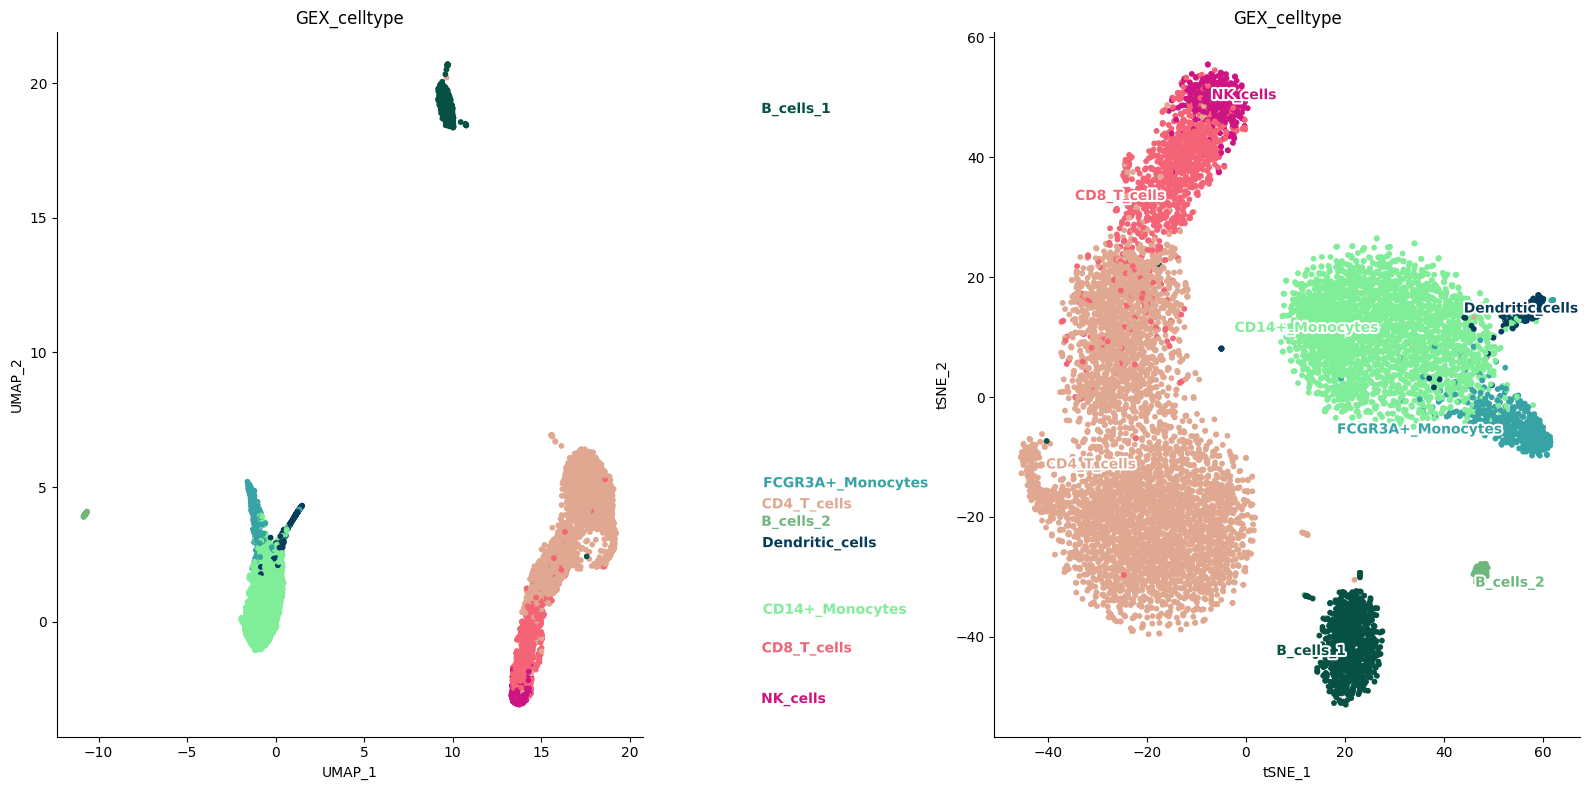

In [58]:
from scenicplus.dimensionality_reduction import plot_metadata_given_ax
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#specify color_dictionary

color_dict = {
    'B_cells_1': "#065143",
    'B_cells_2': "#70B77E",
    'CD4_T_cells': "#E0A890",
    'CD8_T_cells': "#F56476",
    'NK_cells': "#CE1483",
    'Dendritic_cells': "#053C5E" ,
    'FCGR3A+_Monocytes': "#38A3A5",
    'CD14+_Monocytes': "#80ED99"
}

fig, axs = plt.subplots(ncols=2, figsize = (16, 8))
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[0],
    reduction_name = 'eRegulons_UMAP',
    variable = 'GEX_celltype', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_celltype': color_dict}
)
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs[1],
    reduction_name = 'eRegulons_tSNE',
    variable = 'GEX_celltype', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_celltype': color_dict}
)
fig.tight_layout()
sns.despine(ax = axs[0]) #remove top and right edge of axis border
sns.despine(ax = axs[1]) #remove top and right edge of axis border
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

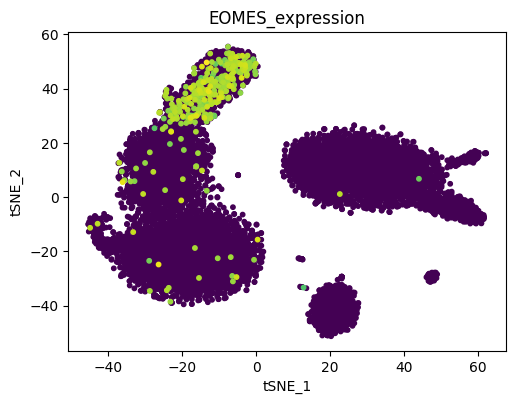

In [59]:
from scenicplus.dimensionality_reduction import plot_eRegulon
plot_eRegulon(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_tSNE',
    selected_regulons = ['EOMES_+', 'GATA3_+', 'TCF7_+', 'CEBPA_+', 'PAX5_+'],
    scale = True,
    auc_key = 'eRegulon_AUC_filtered')

KeyError: 'PAX5_+_(119g)'

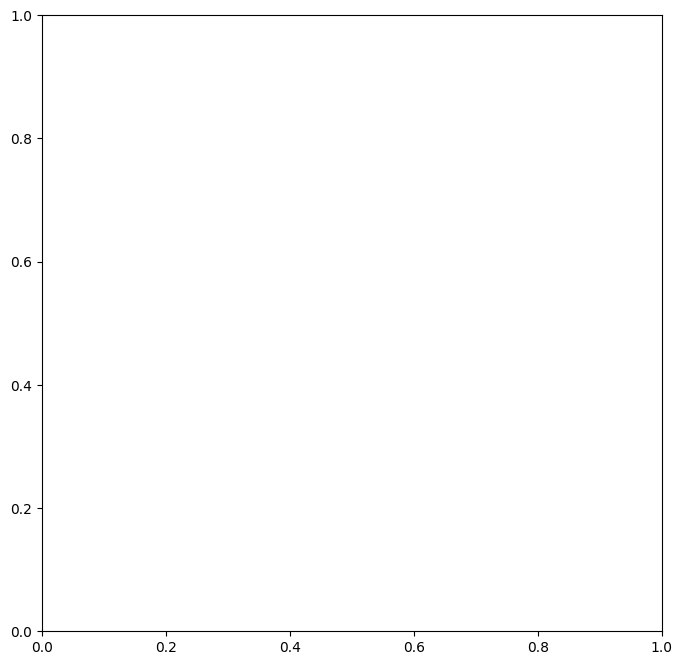

In [60]:
from scenicplus.dimensionality_reduction import plot_AUC_given_ax

fig, ax = plt.subplots(figsize = (8,8))
plot_AUC_given_ax(
    scplus_obj = scplus_obj,
    reduction_name = 'eRegulons_tSNE',
    feature = 'PAX5_+_(119g)',
    ax = ax,
    auc_key = 'eRegulon_AUC_filtered',
    signature_key = 'Gene_based')
sns.despine(ax = ax)
plt.show()

In [61]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [62]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].head()

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,KLF7,KLF7_+_(32r),0.637386,2.043792e-92,3.630737e-92
1,KLF6,KLF6_-_(189r),-0.733004,1.100692e-135,2.865596e-135
2,ATF6,ATF6_extended_-_(13r),-0.622694,4.374475e-87,7.027081e-87
3,MAFG,MAFG_+_(146r),0.609875,1.161575e-82,1.736613e-82
4,CEBPB,CEBPB_+_(1255r),0.864305,2.202230e-240,1.330147e-239


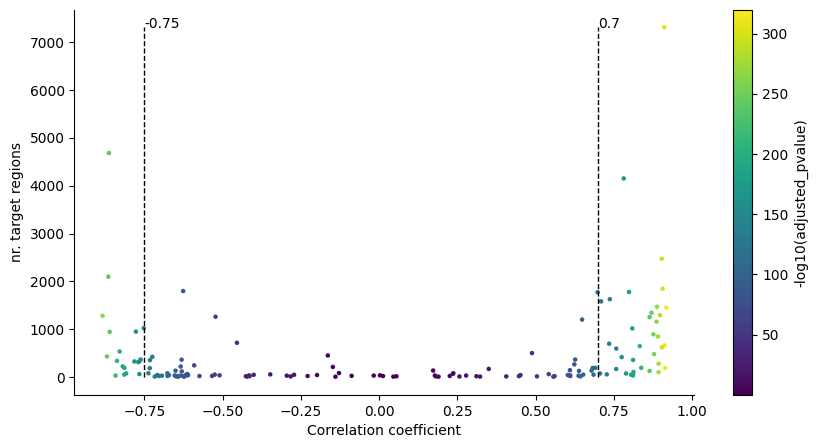

In [63]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.75, 0.70],
        'n_targets': 0
}
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [64]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 59 eRegulons


In [65]:
dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)

In [3]:
import dill
import os
work_dir = './'
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

In [9]:
from scenicplus.plotting.dotplot import heatmap_dotplot
help(heatmap_dotplot)

Help on function heatmap_dotplot in module scenicplus.plotting.dotplot:

heatmap_dotplot(scplus_obj: scenicplus.scenicplus_class.SCENICPLUS, size_matrix: pandas.core.frame.DataFrame, color_matrix: pandas.core.frame.DataFrame, scale_size_matrix: bool = True, scale_color_matrix: bool = True, group_variable: str = None, subset_eRegulons: list = None, sort_by: str = 'color_val', index_order: list = None, save: str = None, figsize: tuple = (5, 8), split_repressor_activator: bool = True, orientation: str = 'vertical')
    Function to generate dotplot dataframe from cistrome AUC enrichment
    
    Parameters
    ----------
    scplus_obj: `class::SCENICPLUS`
        A :class:`SCENICPLUS` object.
    size_matrix: pd.DataFrame
        A pd.DataFrame containing values to plot using size scale.
    color_matrix
        A pd.DataFrame containing values to plot using color scale.
    scale_size_matrix: bool
        Scale size matrix between 0 and 1 along index.
    scale_color_matrix: bool
       

In [10]:
from scenicplus.plotting.dotplot import heatmap_dotplot
aa = heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'GEX_celltype',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        index_order = ['B_cells_1', 'B_cells_2', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Dendritic_cells', 'FCGR3A+_Monocytes', 'CD14+_Monocytes'],
        figsize = (5, 20),
        orientation = 'vertical')

In [13]:
aa.data.to_csv('scenicplus_tf_result.csv')

In [67]:
from scenicplus.RSS import *
regulon_specificity_scores(
        scplus_obj,
        variable = 'GEX_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

2024-01-30 21:28:01,368 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,370 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,372 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,374 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,376 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,378 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,380 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,382 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,384 root         WARNING  Some labels are too long, can't fit inside the X axis
2024-01-30 21:28:01,386 root         WARNING  Some labels are too long, can't fit inside the X axis


AttributeError: FancyArrowPatch.set() got an unexpected keyword argument 'autoalign'

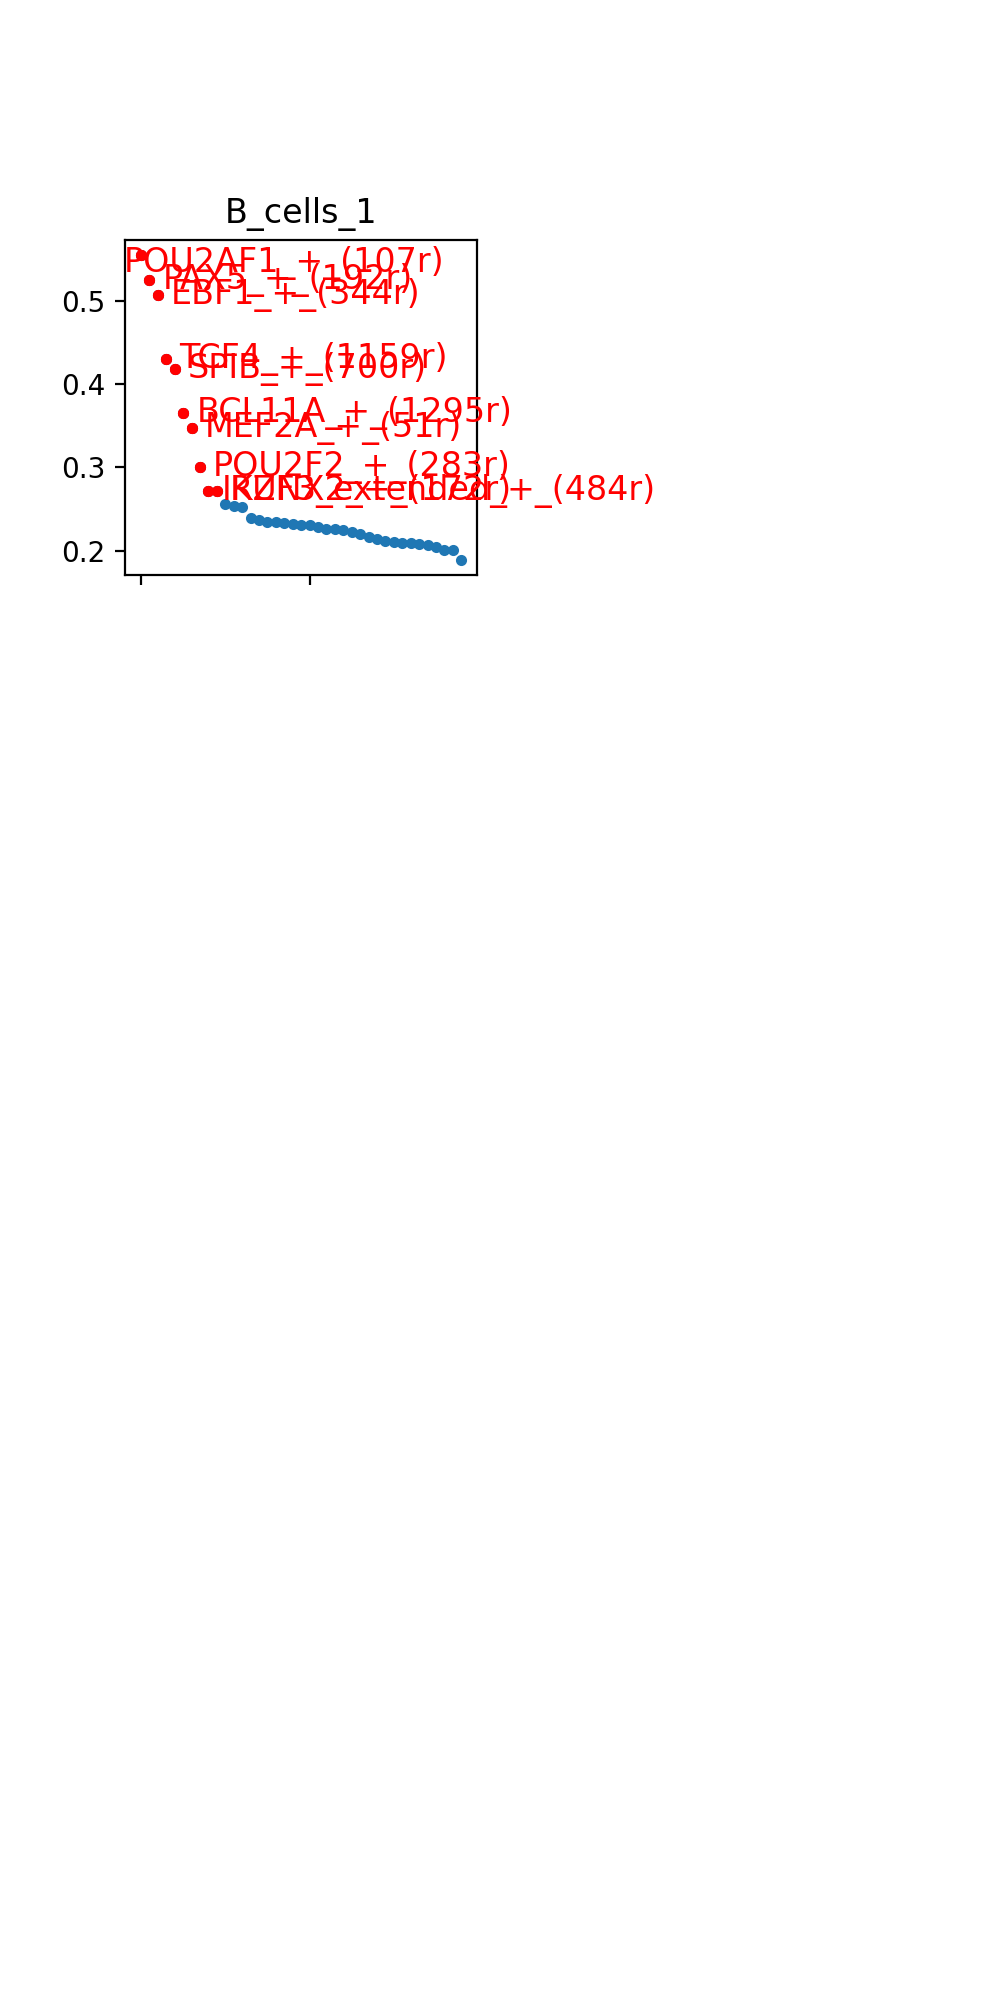

In [68]:
plot_rss(scplus_obj, 'GEX_celltype_filtered', num_columns=2, top_n=10, figsize = (5, 10))

In [69]:
flat_list = lambda t: [item for sublist in t for item in sublist]
selected_markers = list(set(flat_list(
    [scplus_obj.uns['RSS']['GEX_celltype_filtered'].loc[celltype].sort_values(ascending = False).head(10).index.to_list()
    for celltype in scplus_obj.uns['RSS']['GEX_celltype_filtered'].index])))

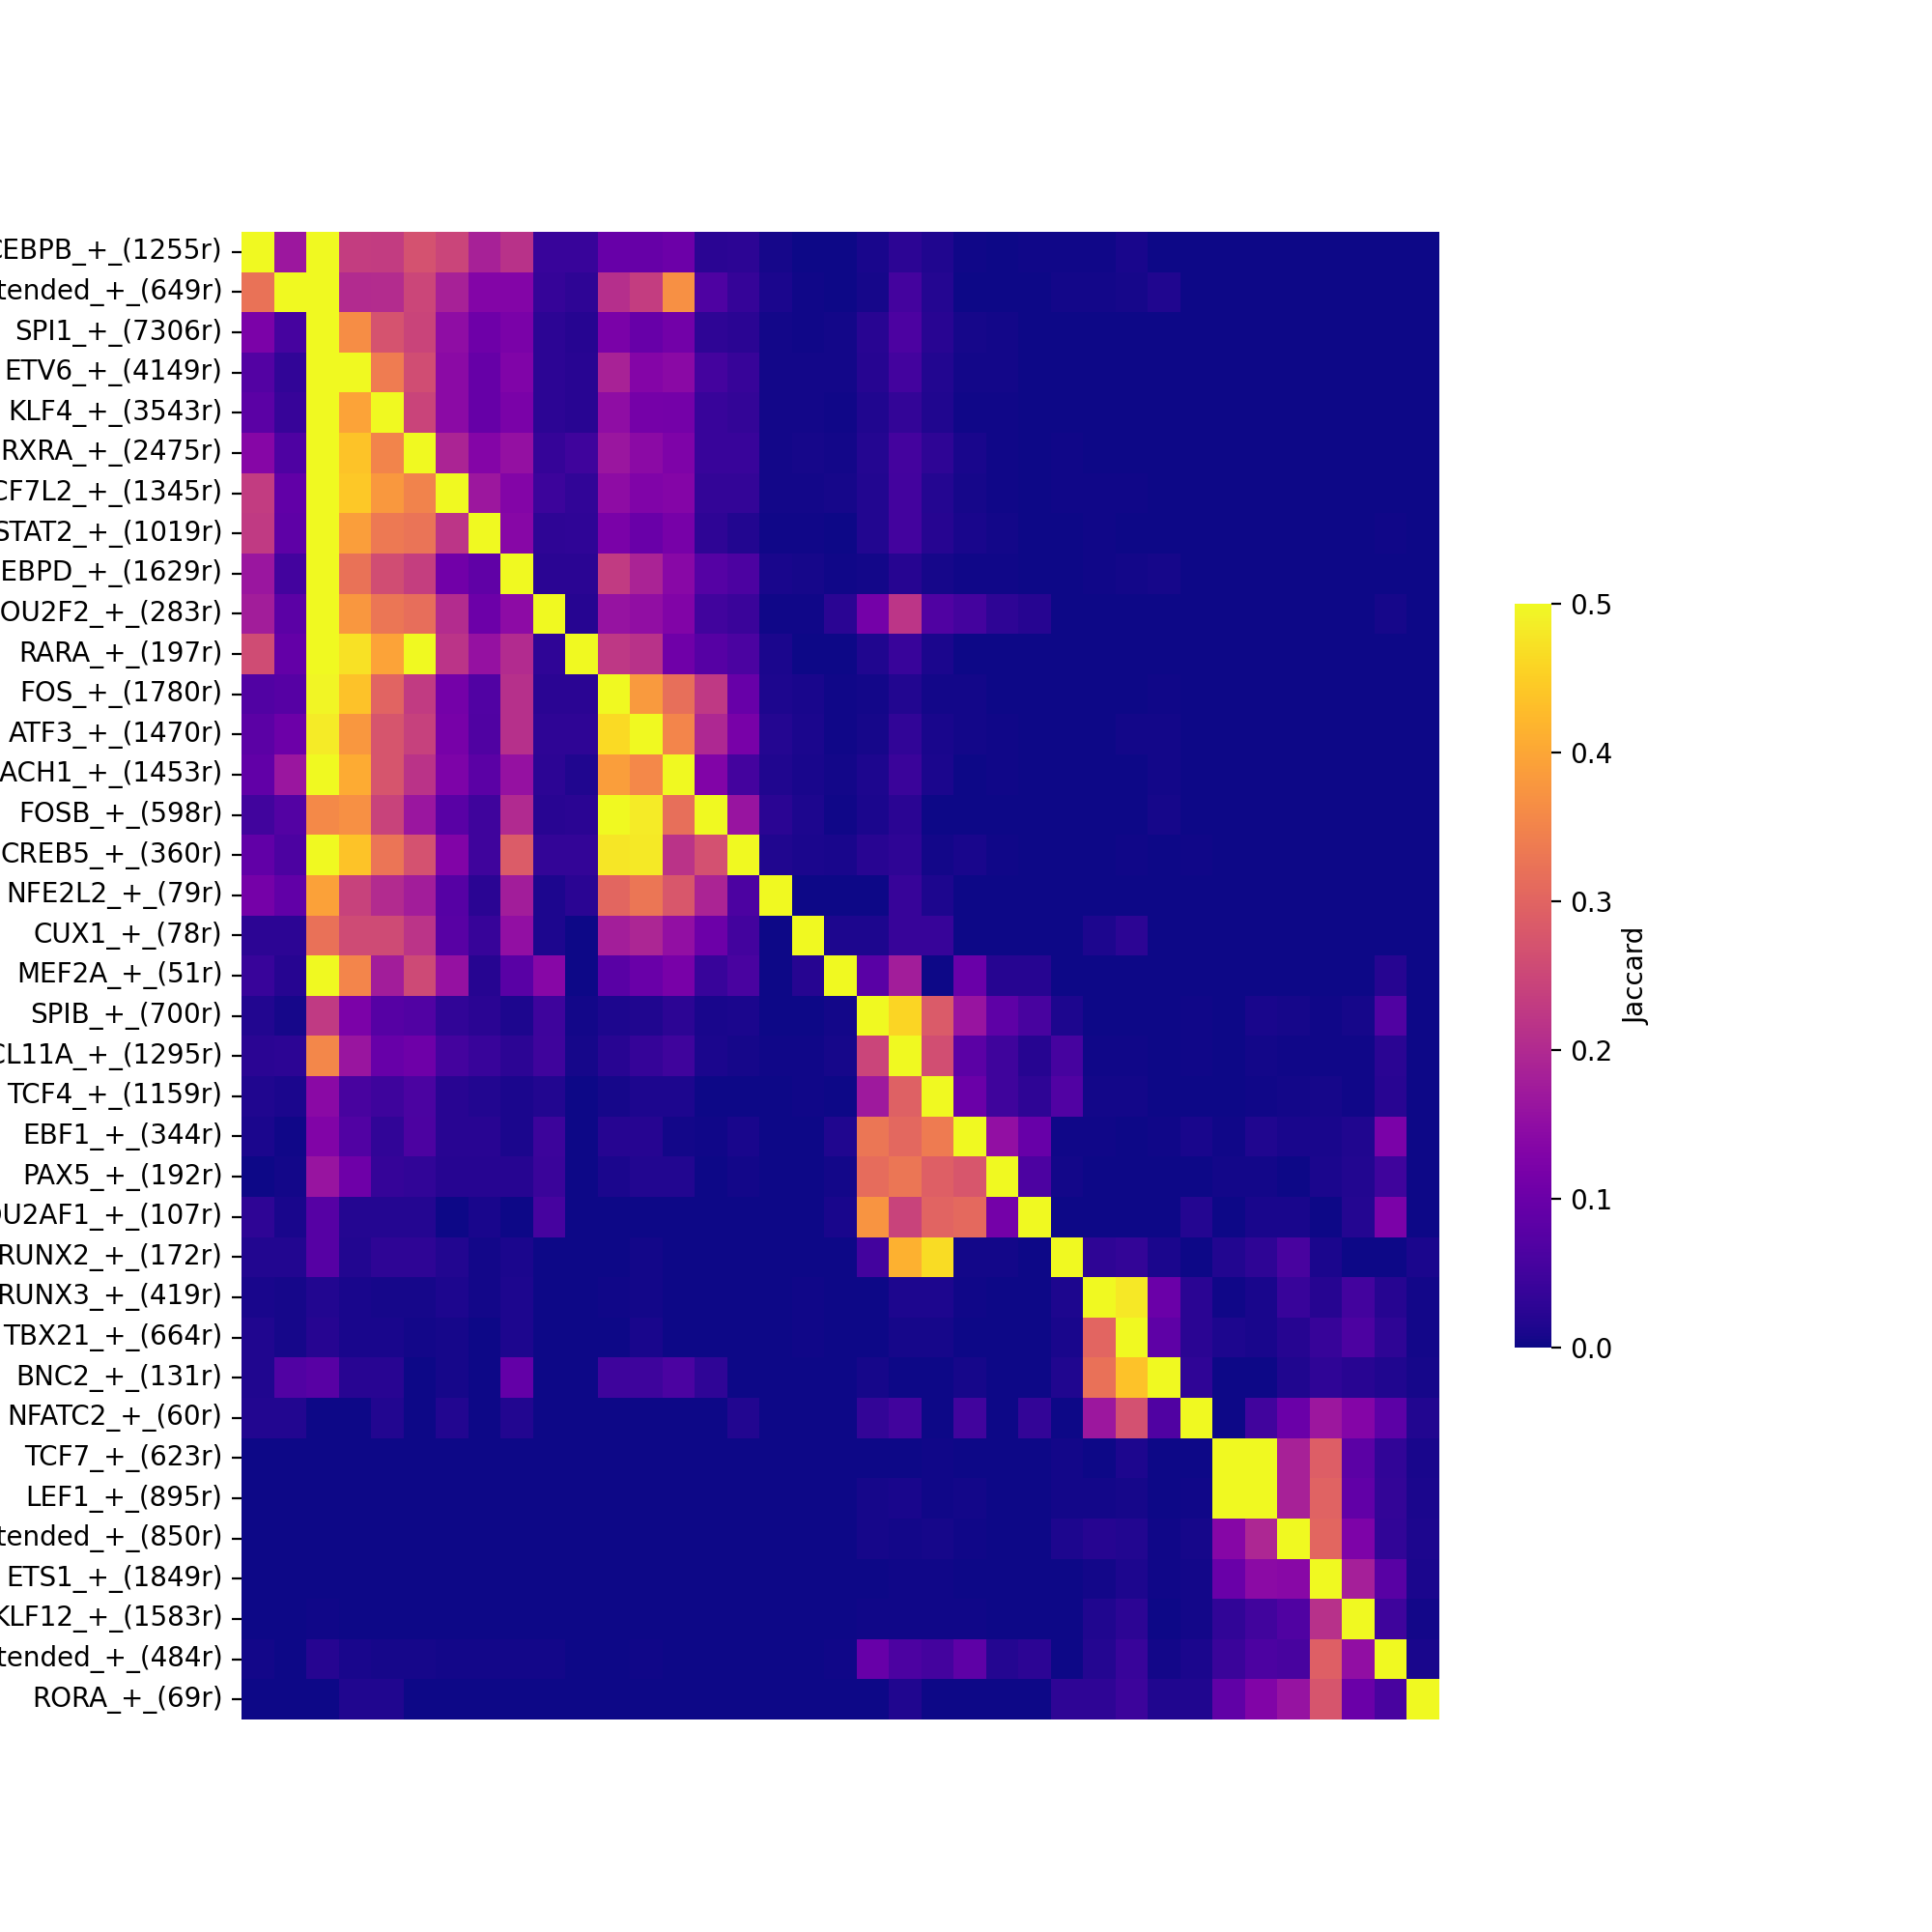

In [70]:
from scenicplus.plotting.correlation_plot import *

region_intersetc_data, Z = jaccard_heatmap(
        scplus_obj,
        method = 'intersect',
        gene_or_region_based = 'Region_based',
        use_plotly = False,
        selected_regulons = selected_markers,
        signature_key = 'eRegulon_signatures_filtered',
        figsize = (10, 10), return_data = True, vmax = 0.5, cmap = 'plasma')

In [71]:
from pycisTopic.diff_features import find_highly_variable_features
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=1000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=1000, plot = False)

2024-01-30 21:30:02,697 cisTopic     INFO     Calculating mean
2024-01-30 21:30:02,838 cisTopic     INFO     Calculating variance
2024-01-30 21:30:04,360 cisTopic     INFO     Done!
2024-01-30 21:30:04,589 cisTopic     INFO     Calculating mean
2024-01-30 21:30:04,612 cisTopic     INFO     Calculating variance
2024-01-30 21:30:04,816 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [72]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
    subset_eRegulons = ['PAX5', 'EBF1', 'POU2AF1'],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['GEX_celltype'])

In [73]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables,
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'PAX5': 'Orange', 'EBF1': 'Purple', 'POU2AF1': 'Red'}},
                                    'R2G': {'variable' : 'R2G_rho', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'R2G_importance', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'R2G_importance', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'TF', 'category_color' : {'PAX5': 'Orange', 'EBF1': 'Purple', 'POU2AF1': 'Red'}},
                                    'Gene': {'variable': 'GEX_celltype_Log2FC_B_cells_1', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'GEX_celltype_Log2FC_B_cells_1', 'continuous_color' : 'viridis'}},
                   transparency_node_by =  {'Region': {'variable' : 'GEX_celltype_Log2FC_B_cells_1', 'min_alpha': 0.1},
                                    'Gene': {'variable' : 'GEX_celltype_Log2FC_B_cells_1', 'min_alpha': 0.1}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 30},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 15},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 10}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 10.0},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=250)

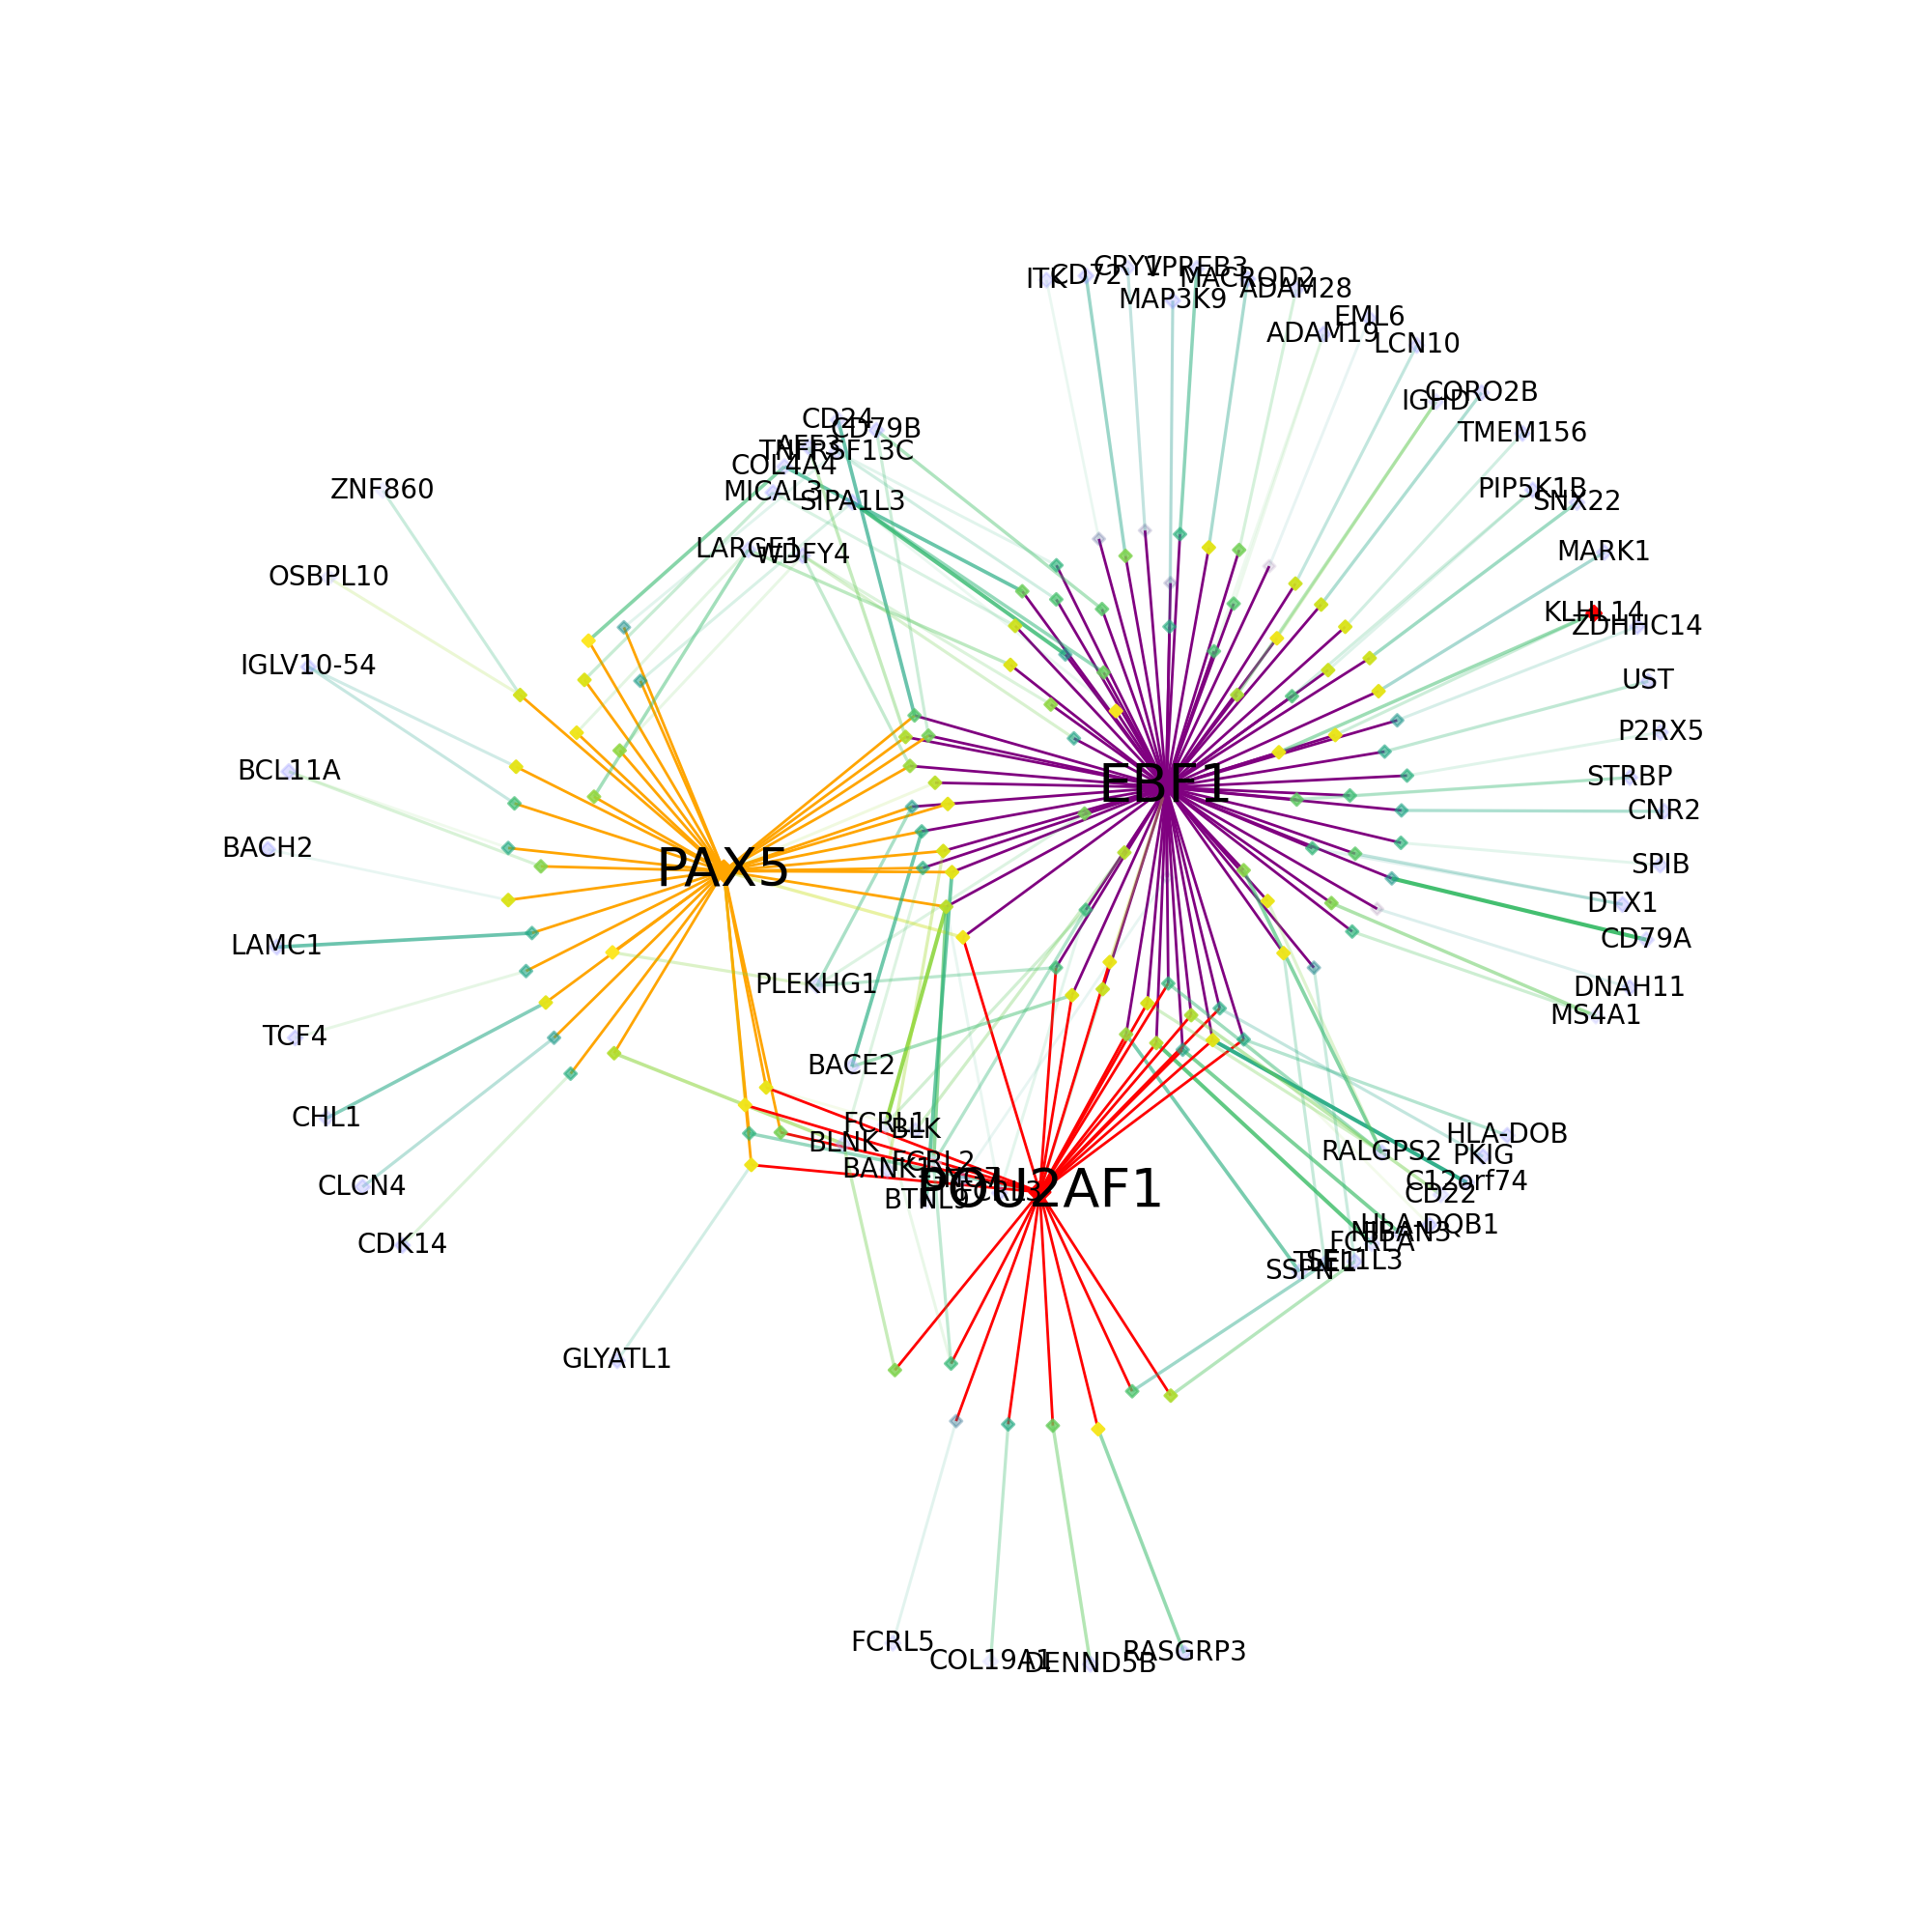

In [74]:
plt.figure(figsize=(10,10))
plot_networkx(G, pos)

In [75]:
export_to_cytoscape(G, pos, out_file = os.path.join(work_dir, 'scenicplus/network_B_cells.cys'))